In [265]:
import sys
sys.path.append("/home/conradb/git/ifg-ssl")
import os
import torch
import torchvision.transforms.v2 as transforms 
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import ImageFile

import MAE.models_mae as models_mae

In [273]:
def show_image(image, title=''):
    # image is [H x W x 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image*255), 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)
    x = x.unsqueeze(dim=0)
    print(x.shape)
    # x = torch.einsum('nhwc->nchw', x)
    # print(x.shape)

    loss, y, mask = model(x.float(), mask_ratio=0.35)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()


<PIL.Image.Image image mode=RGB size=839x766 at 0x7F06A00C4A90>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F06E83720D0>
(224, 224, 3)


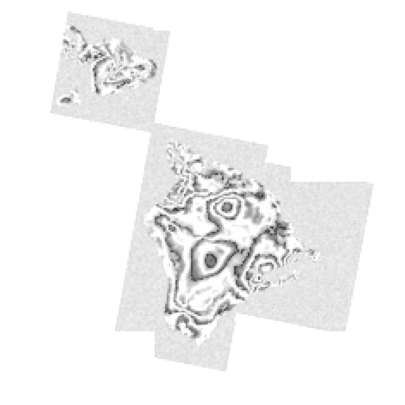

In [275]:
# 2018 Kīlauea 
# U:\scratch\SDF25\LiCSAR-web-tools\087D_07004_060904\interferograms\20180411_20180511\20180411_20180511.geo.diff.png
# U:\scratch\SDF25\LiCSAR-web-tools\087D_07004_060904\interferograms\20180423_20180505\20180423_20180505.geo.diff.png

# img_path = '/scratch/SDF25/LiCSAR-web-tools/087D_07004_060904/interferograms/20180411_20180511/20180411_20180511.geo.diff.png'
img_path = '/scratch/SDF25/LiCSAR-web-tools/087D_07004_060904/interferograms/20180423_20180505/20180423_20180505.geo.diff.png'

img = ImageFile.Image.open(img_path).convert('RGB')
print(img)
img = img.resize((224,224))
print(img)
t = transforms.Compose([transforms.ColorJitter(brightness=.5, hue=.3), transforms.Grayscale(num_output_channels=3)])
img = t(img)
# img = np.tile(np.array(img), (3,1,1)).transpose(1,2,0)/255
# print(img.shape)
img = np.array(img) /255
print(img.shape)

assert img.shape == (224, 224, 3)

plt.rcParams['figure.figsize'] = [10, 5]
show_image(torch.tensor(img))

torch.Size([3, 224, 224])
tensor([[0.9725, 0.9725, 0.9647,  ..., 0.8549, 0.8078, 0.7490],
        [0.9333, 0.9686, 0.9804,  ..., 0.9255, 0.8863, 0.8353],
        [0.9020, 0.9451, 0.9804,  ..., 0.9647, 0.9373, 0.9137],
        ...,
        [0.8627, 0.8314, 0.8000,  ..., 0.4941, 0.4941, 0.5843],
        [0.8157, 0.8118, 0.8078,  ..., 0.4627, 0.5098, 0.6157],
        [0.7373, 0.7725, 0.8078,  ..., 0.4706, 0.6039, 0.6784]])
tensor([[0.9843, 0.9569, 0.9569,  ..., 0.7490, 0.7490, 0.6667],
        [0.8667, 0.9843, 0.9843,  ..., 0.8667, 0.8667, 0.8510],
        [0.8667, 0.9843, 0.9843,  ..., 0.8667, 0.8667, 0.8510],
        ...,
        [0.8314, 0.8314, 0.8314,  ..., 0.4196, 0.4196, 0.7137],
        [0.8314, 0.8314, 0.8314,  ..., 0.4196, 0.4196, 0.7137],
        [0.7725, 0.7882, 0.7882,  ..., 0.5020, 0.5020, 0.7137]])


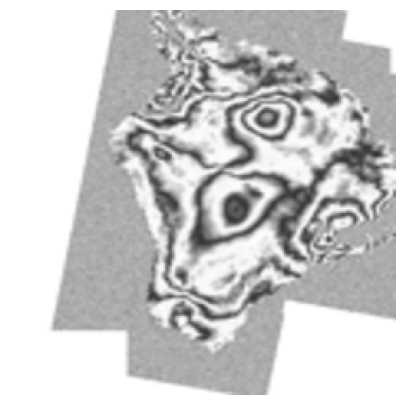

In [276]:
#Transform Grayscale + ToTensor (which normalizes /255)
seed = 93
torch.manual_seed(seed)
random.seed(seed)

img1 = ImageFile.Image.open(img_path).convert('RGB')
img1 = img1.resize((224,224))
img2 = ImageFile.Image.open(img_path)
img2 = img2.resize((224,224))
transform = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.1, 1.0), interpolation=3), transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])
# transform = transforms.Compose([transforms.CenterCrop(size=(224,224)), transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])

img1, img2 = transform(img1, img2)
print(img1.shape)
show_image(img1.permute(1,2,0))

print(img1[0, 100:150, 100:150])
print(img2[0, 100:150, 100:150])

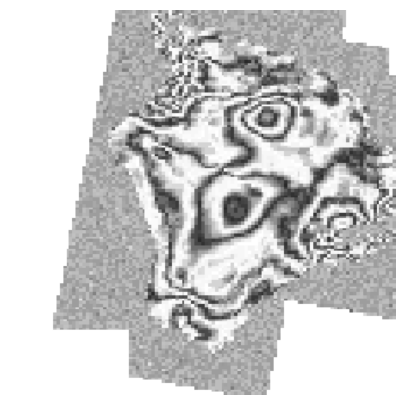

In [277]:
show_image(img2.permute(1,2,0))

In [278]:
chkpt_dir = '/home/conradb/git/ifg-ssl/hephaestus/checkpoints/Hephaestus_MAE_VitB16_224_no_os_no_norm_2000e_75msk_1-5e4lr.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')

<All keys matched successfully>


/tmp/ipykernel_101239/1205579530.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


torch.Size([1, 3, 224, 224])


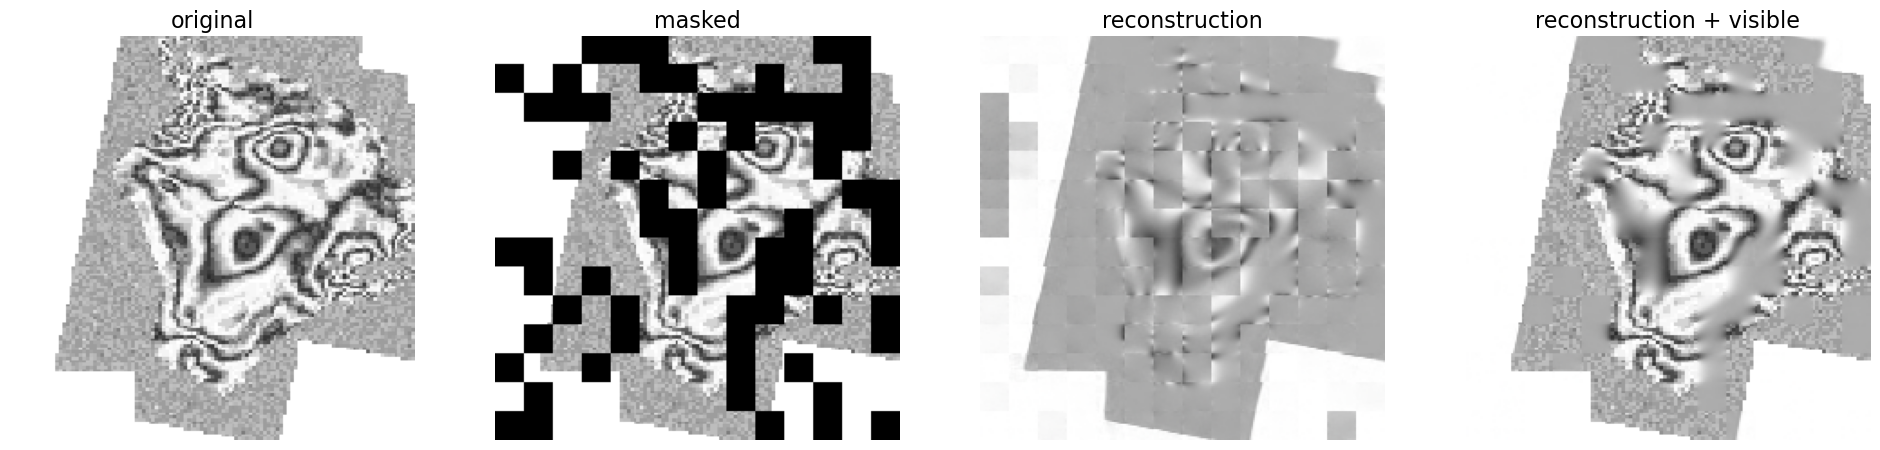

In [279]:
run_one_image(img2, model_mae)

/tmp/ipykernel_101239/1205579530.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


torch.Size([1, 3, 224, 224])


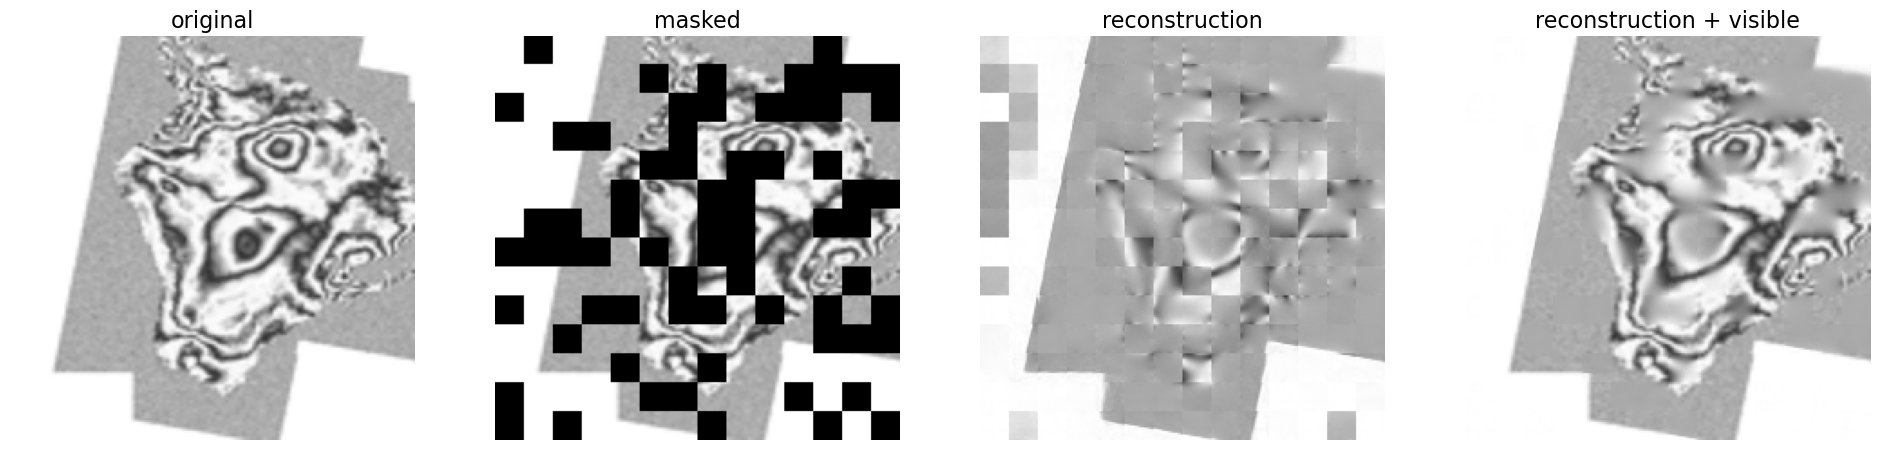

In [280]:
run_one_image(img1, model_mae)